# Exploration of Cell Composition

We know that cell composition is a key confounder when looking at changes in the methylome and how they relate to HIV infected patients. It is well understood that individuals with HIV have lower CD4 counts, for this reason we have pretty comprehesive blood work for these cases. Unfortunately we do not have the same blood work for the controls. For this reason we are using the estimateCellCounts function in the R [minfi](http://www.bioconductor.org/packages/release/bioc/html/minfi.html) package to get cell composition for all of our samples.  

The estimateCellCounts function uses differentially methylated probes across different flow-sorted cell populations to estimate blood composition via mixture modeling.  For this we need arrays measuring methylation of each cell population we want to estimate.  While we do not have the exact same cell-types reported in our blood composition report, we can benchmark this method against those that we do have.

In [1]:
import os 
if os.getcwd().endswith('Benchmarks'):
    os.chdir('..')

Imports and helper functions from [Imports](Imports.ipynb) notebook.

In [2]:
import NotebookImport
from HIV_Age_Advancement import *

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

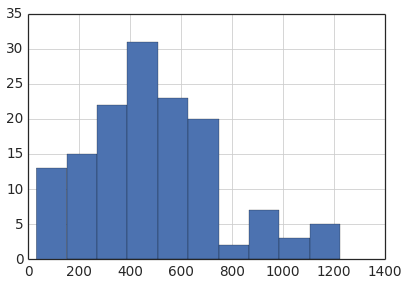

In [3]:
labs['CD4 Absolute'].hist()

### Cell Composition from estimateCellCounts

Looking for changes in cell composition with HIV

In [4]:
duration = duration.ix[pred_c.index]

In [5]:
screen_feature(duration=='Control', kruskal_pandas, cell_counts.T, align=False)

,H,p,q
CD8T,56.18,6.61e-14,3.96e-13
CD4T,45.38,1.62e-11,4.86e-11
Gran,6.70,9.62e-03,1.92e-02
Bcell,5.31,2.12e-02,3.19e-02
NK,3.50,6.15e-02,7.38e-02
Mono,1.35,2.46e-01,2.46e-01


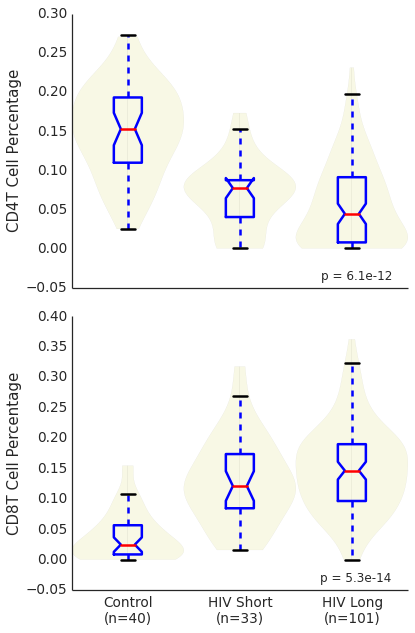

In [6]:
fig, axs = subplots(2,1, figsize=(6,9), sharex=True)
o = ['Control','HIV Short','HIV Long']
violin_plot_pandas(duration, cell_counts.CD4T, order=o, ax=axs[0])
violin_plot_pandas(duration, cell_counts.CD8T, order=o, ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xlabel('')
axs[0].set_ylabel('CD4T Cell Percentage')
axs[1].set_ylabel('CD8T Cell Percentage')
fig.tight_layout()
fig.savefig(FIGDIR + 'tcells.png', dpi=300)

In [7]:
((cell_counts.CD8T + .01) / (cell_counts.CD4T + .01)).groupby(duration=='Control').mean()

estimated duration hiv (months)
False    5.11
True     0.35
dtype: float64

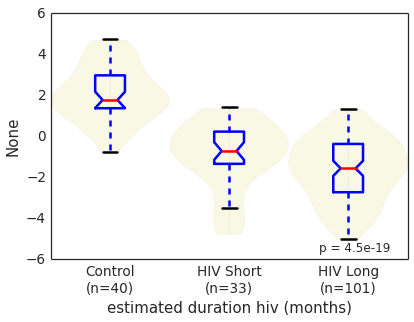

In [8]:
violin_plot_pandas(duration, np.log2((cell_counts.CD4T + .01) / (cell_counts.CD8T + .01)), 
                   order=['Control','HIV Short','HIV Long'])

### Cell Counts from the Labs

In [9]:
cell_types = ['Neutrophil %','Lymphocyte %','Monocyte %','Eosinophil %','Basophil %']
labs[cell_types].sum(1).order()

RG065      6.0
RG175     25.3
RG153     96.0
RA282     96.0
RD115     99.0
RP068     99.0
RP272     99.0
RP238     99.0
RP027     99.0
RA127     99.0
RP097     99.0
RP111     99.0
RD186     99.0
RD054     99.0
RP053     99.0
RA154     99.0
RA208     99.0
RG265     99.1
RM078     99.2
RM292     99.3
RD079     99.3
RM034     99.5
RM305     99.5
RG276     99.6
RM051     99.7
RG240     99.7
RM139     99.7
RG174     99.8
RG060     99.8
RM067     99.8
         ...  
RD117    100.5
RG056    100.5
RM079    100.6
RM258    100.7
RM328    100.7
RM293    100.7
RG239    100.9
RP125    101.0
RP112    101.0
RP266    101.0
RP105    101.0
RP023    101.0
RP300    101.0
RD073    101.0
RD189    101.0
RP285    101.0
RM361    101.0
RD250    101.0
RA307    101.0
RP077    101.0
RD168    101.0
RD272    101.0
RG341    101.0
RP109    101.0
RP029    101.0
RG164    101.2
RD002    101.3
RD234    102.0
RM285    128.5
RA182    130.0
dtype: float64

* Dropping five patients because they don't look Kosher  
* Renormalizing cell percentages because some don't sum to 100%

In [10]:
keepers = labs.index.difference(['RG065','RG175','RG279','RA182','RM285'])
keepers = keepers.intersection(duration.index)
l3 = labs[cell_types].div(labs[cell_types].sum(1), axis=0) * 100
l3 = l3.ix[keepers]

In [11]:
reg_cd4 = linear_regression(labs['CD4 Absolute'].ix[keepers], 
                            cell_counts.CD4T)
reg_cd8 = linear_regression(labs['CD8 Absolute'].ix[keepers], 
                            cell_counts.CD8T)

In [12]:
import seaborn as sns

sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")

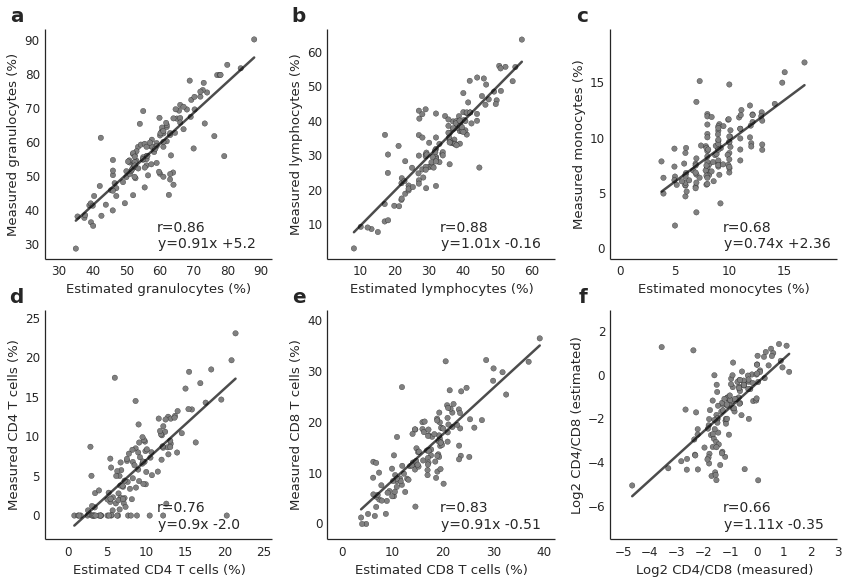

In [13]:
fig, axs2 = subplots(2,3, figsize=(12,8))
axs = axs2[0]
ll = {'color':'black','alpha':.7, 'ls':'-'}
plot_regression((l3['Neutrophil %'] + l3['Eosinophil %'] + l3['Basophil %']).dropna(),
                cell_counts.Gran.ix[keepers] * 100, ax=axs[0],
                line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')
axs[0].set_xlabel('Estimated granulocytes (%)')
axs[0].set_ylabel('Measured granulocytes (%)');

plot_regression(l3['Lymphocyte %'].ix[keepers],
                cell_counts[['Bcell','NK','CD4T','CD8T']].sum(1) * 100,
                ax=axs[1], line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')
axs[1].set_xlabel('Estimated lymphocytes (%)')
axs[1].set_ylabel('Measured lymphocytes (%)');

plot_regression(l3['Monocyte %'].ix[keepers], cell_counts['Mono'] * 100,
                ax=axs[2], line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')
axs[2].set_xlabel('Estimated monocytes (%)')
axs[2].set_ylabel('Measured monocytes (%)')

axs = axs2[1]
plot_regression((labs['CD4 %'].ix[keepers] * l3['Lymphocyte %']) / 100., 
                cell_counts.CD4T * 100, 
                ax=axs[0], line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')
axs[0].set_xlabel('Estimated CD4 T cells (%)')
axs[0].set_ylabel('Measured CD4 T cells (%)')


plot_regression((labs['CD8 %'].ix[keepers] * l3['Lymphocyte %']) / 100., 
                cell_counts.CD8T * 100, 
                ax=axs[1], line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')
axs[1].set_xlabel('Estimated CD8 T cells (%)')
axs[1].set_ylabel('Measured CD8 T cells (%)')

plot_regression(np.log2(labs['CD4/CD8 ratio'].ix[keepers]), 
               np.log2(((cell_counts.CD4T + .01) / (cell_counts.CD8T + .01))),
               ax=axs[2], line_args=[ll,{'alpha':0}],
                s=30, color='grey', alpha=1, edgecolor='black')

axs[2].set_ylabel('Log2 CD4/CD8 (estimated)')
axs[2].set_xlabel('Log2 CD4/CD8 (measured)')
axs[2].set_xbound(-5.5,3)
axs[2].set_ybound(-7.5,3)


letters = list(map(chr, range(97, 123)))[:6] 
for i,ax in enumerate(axs2.flatten()):
    ax.text(-0.1, 1.1, letters[i], transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='right')
    prettify_ax(ax)
    
fig.tight_layout()
fig.savefig(FIGDIR + 'figS1.pdf', transparent=False)

In [14]:
c1 = (labs['CD4 %'].ix[keepers] * l3['Lymphocyte %']) / 100.
c2 = cell_counts.CD4T * 100

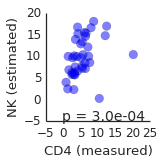

In [15]:
fig, ax = subplots(figsize=(2.5,2.5))
series_scatter((c1).ix[ti(c2 < 2)], cell_counts.NK * 100, ax=ax)
prettify_ax(ax)
ax.set_xlabel('CD4 (measured)')
ax.set_ylabel('NK (estimated)')
fig.tight_layout()
fig.savefig(FIGDIR + 'inset.png', dpi=300)

# Mockup of Cell-Composition Adjustment 

Real adjustment is done in [BMIQ_Normalization](../../PreProcessing/Normalize_For_Horvath/BMIQ_Normalization.ipynb) notebook.

In [16]:
betas = pd.read_hdf('/data_ssd/dx_methylation.h5', 'betas')
betas = betas['s2'].ix[:, duration.index]
betas = betas.groupby(level=0).first()

In [17]:
flow_sorted_data = pd.read_hdf('/data_ssd/methylation_annotation.h5','flow_sorted_data')
cell_type = pd.read_hdf('/data_ssd/methylation_annotation.h5', 'label_map')

In [18]:
n2 = flow_sorted_data.groupby(cell_type, axis=1).median()
avg = n2[cell_counts.columns].dot(cell_counts.T)

In [19]:
b1 = logit_adj(betas).T.corrwith(cell_counts.CD8T)
b2 = logit_adj(df_hiv).ix[:, betas.columns].T.corrwith(cell_counts.CD8T)

In [20]:
ss = avg.std(1)

In [21]:
b1 = b1.groupby(level=0).first()
b2 = b2.groupby(level=0).first()

In [22]:
idx = b1.abs() > .01
(b1[idx].abs() < b2[idx].abs()).value_counts()

False    325147
True     144584
dtype: int64

In [23]:
from scipy.stats import binom_test

In [24]:
binom_test((b1.abs() < b2.abs()).value_counts())

2.4703282292062327e-323

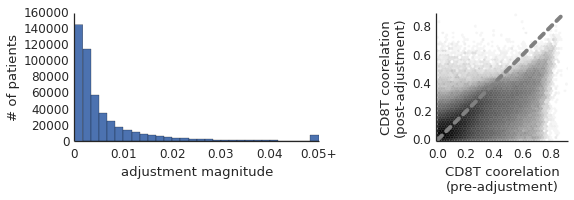

In [25]:
fig, axs = subplots(1,2, figsize=(9,3))

ss.clip_upper(.05).hist(bins=30, ax=axs[0])
axs[0].set_xticks([0,.01,.02,.03,.04,.05])
axs[0].set_xticklabels([0,.01,.02,.03,.04,'0.05+'])
axs[0].set_xlabel('adjustment magnitude')
axs[0].set_ylabel('# of patients')

axs[1].hexbin(*match_series(b1.abs(), b2.abs()), gridsize=50,
              bins='log')
axs[1].set_aspect(1)
axs[1].plot([0,.9],[0,.9], color='grey', lw=4, ls='--', dash_capstyle='round')
axs[1].set_xlabel('CD8T coorelation \n(pre-adjustment)')
axs[1].set_ylabel('CD8T coorelation \n(post-adjustment)')

for ax in axs:
    prettify_ax(ax)
    
fig.tight_layout()

In [26]:
flow_sorted_data.T.groupby(cell_type == 'CD8T').mean().diff().ix[1].order().ix[500:].head(10)

cg23364656   -0.43
cg10416784   -0.43
cg19163395   -0.43
cg07182248   -0.43
cg04780380   -0.43
cg02078710   -0.43
cg18473733   -0.43
cg26485825   -0.43
cg05897963   -0.43
cg10440516   -0.43
Name: True, dtype: float64

In [27]:
p = 'cg19163395'

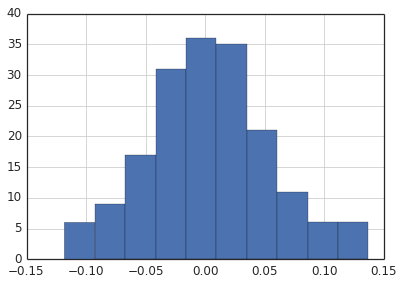

In [28]:
diff = avg.ix[p].ix[duration.index] - avg.ix[p].median()
diff.hist()

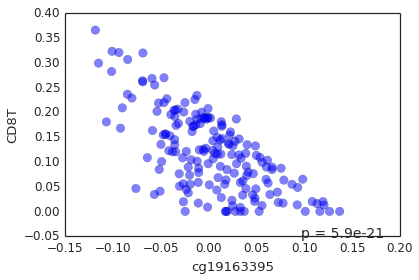

In [29]:
series_scatter(diff, cell_counts.CD8T)

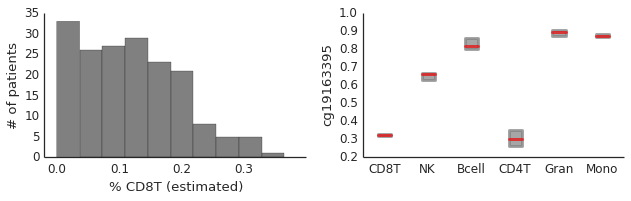

In [30]:
fig, axs = subplots(1,2, figsize=(9,3))
cell_counts.CD8T.ix[duration.index].hist(color='grey', ax=axs[0])
axs[0].set_xlabel('% CD8T (estimated)')
axs[0].set_xticks([0,.1,.2,.3])
axs[0].set_ylabel('# of patients')
box_plot_pandas(cell_type[cell_type.isin(cell_counts.columns)], 
                flow_sorted_data.ix[p], ax=axs[1],
                order=['CD8T','NK','Bcell','CD4T','Gran','Mono'])
axs[0].set_xlim(-.02,.4)
for ax in axs:
    prettify_ax(ax)
fig.tight_layout()
fig.savefig(FIGDIR + 'Adjust_ab.pdf')

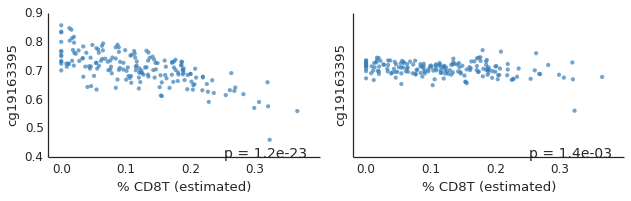

In [31]:
fig, axs = subplots(1,2, figsize=(9,3), sharey=True)
series_scatter(cell_counts.CD8T, betas.ix[p].ix[diff.index],
               ax=axs[0], color=colors[1], alpha=.7, s=15)
series_scatter(cell_counts.CD8T, betas.ix[p].ix[diff.index] - diff,
               ax=axs[1], color=colors[1], alpha=.7, s=15)
for ax in axs:
    prettify_ax(ax)
    ax.set_xlabel('% CD8T (estimated)')
    ax.set_xticks([0,.1,.2,.3])
    ax.set_xlim(-.02,.4)
fig.tight_layout()
fig.savefig(FIGDIR + 'Adjust_cd.pdf')

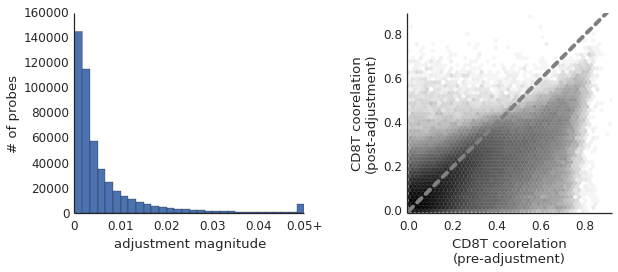

In [32]:
fig, axs = subplots(1,2, figsize=(9,4))

ss.clip_upper(.05).hist(bins=30, ax=axs[0])
axs[0].set_xticks([0,.01,.02,.03,.04,.05])
axs[0].set_xticklabels([0,.01,.02,.03,.04,'0.05+'])
axs[0].set_xlabel('adjustment magnitude')
axs[0].set_ylabel('# of probes')

axs[1].hexbin(*match_series(b1.abs(), b2.abs()), gridsize=50,
              bins='log')
axs[1].set_aspect(1)
axs[1].plot([0,.9],[0,.9], color='grey', lw=4, ls='--', dash_capstyle='round')
axs[1].set_xlabel('CD8T coorelation \n(pre-adjustment)')
axs[1].set_ylabel('CD8T coorelation \n(post-adjustment)')

for ax in axs:
    prettify_ax(ax)
    
fig.tight_layout()
fig.savefig(FIGDIR + 'Adjust_ef.pdf')

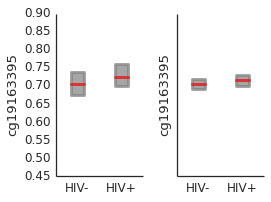

In [33]:
fig, axs = subplots(1,2, figsize=(4,3), sharey=True)
hiv = (duration=='Control').map({True:'HIV+',False:'HIV-'})
hiv.name = ''
box_plot_pandas(hiv, betas.ix[p], ax=axs[0])
box_plot_pandas(hiv, (betas - diff).ix[p], ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xticklabels(['HIV-','HIV+'])
fig.tight_layout()

In [34]:
from Benchmarks.Model_Comparison_MF import *

importing IPython notebook from Benchmarks/Model_Comparison_MF

importing IPython notebook from Benchmarks/Age_Models_All_Patients

In [35]:
pts = mc_adj_c.index
rr = screen_feature(age.ix[pts], pearson_pandas, cell_counts.T, align=False)
rr

,rho,p,q
CD8T,-0.14,1.66e-06,9.94e-06
NK,0.09,1.20e-03,3.59e-03
Mono,0.05,6.62e-02,1.32e-01
Bcell,0.05,9.30e-02,1.40e-01
Gran,-0.02,5.50e-01,5.72e-01
CD4T,-0.02,5.72e-01,5.72e-01


In [36]:
pts = mc_adj_c.index
rr = screen_feature(mc_adj_c.ix[pts] - age, pearson_pandas, cell_counts.T, align=False)
rr

,rho,p,q
Bcell,-0.20,1.95e-12,1.17e-11
Gran,0.12,4.26e-05,1.28e-04
CD4T,-0.09,3.23e-03,6.45e-03
NK,0.08,4.75e-03,7.12e-03
Mono,0.08,7.23e-03,8.67e-03
CD8T,-0.05,7.52e-02,7.52e-02


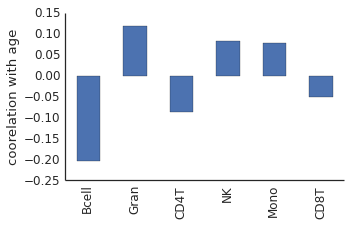

In [37]:
fig, ax = subplots(figsize=(5,3))
rr.rho.plot(kind='bar', ax=ax)
ax.set_ylabel('coorelation with age')
ax.set_xlim(-.5, 5.5)
prettify_ax(ax)

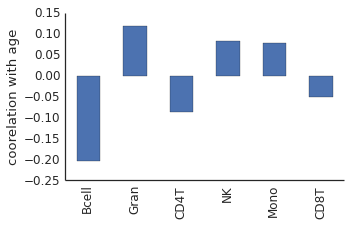

In [38]:
fig, ax = subplots(figsize=(5,3))
rr.rho.plot(kind='bar', ax=ax)
ax.set_ylabel('coorelation with age')
ax.set_xlim(-.5, 5.5)
prettify_ax(ax)